In [1]:
#librerías
import numpy as np
import matplotlib.pyplot as plt #gráficos
from scipy import interpolate #interpolación 1
from scipy.interpolate import griddata #interpolación 2
import h5py #archivos en hdf5
from jupyterlab_h5web import H5Web #librería
from pathlib import Path, PurePath #manejo de rutas y archivos
%run -i ./Funciones.py #funciones importante
from scipy.interpolate import UnivariateSpline
    

#Latex y coma como separador decimal
plt.rcParams['text.usetex'] = True #latex
#plt.rc('text', usetex=False)
plt.rcParams['axes.formatter.use_locale'] = True #formato de eje para la coma
#se incluye paquete matematico útil, se corrige el error con el espacio y el espacio entre los números
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \DeclareUnicodeCharacter{202F}{\,} \usepackage{ziffer} \usepackage{siunitx} \sisetup{output-decimal-marker = {,}}') 
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

import locale #líbreria para el formato
locale.setlocale(locale.LC_ALL, "es_CR.utf8")

'es_CR.utf8'

(98, 40, 48)


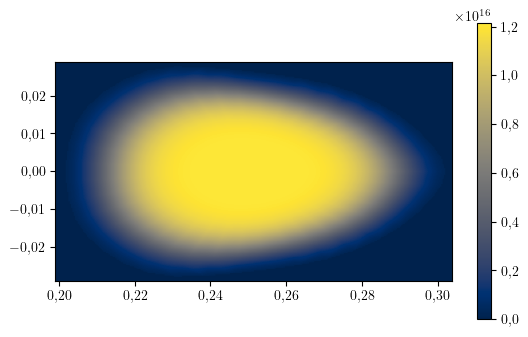

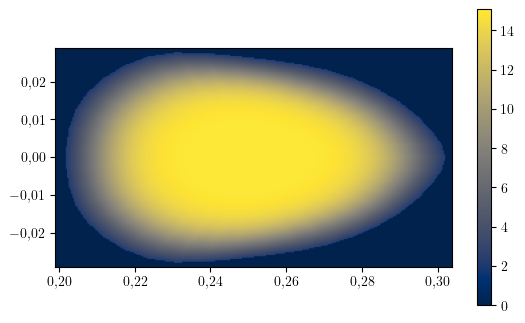

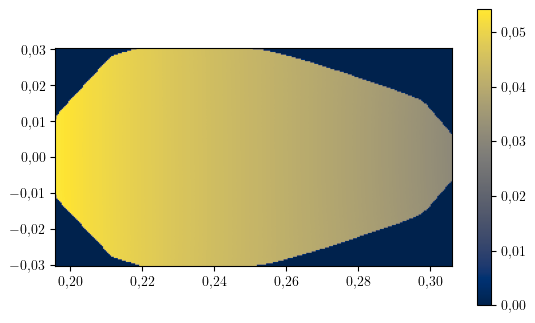

In [2]:
ruta_campo = 'ne_Te_r_z_B/r+z+B_mag_componentes.txt'
ruta_ne = 'ne_Te_r_z_B/densidad.txt'
#ruta_ne = 'ne_Te_r_z_B/densidad_perfil_2.txt'
ruta_Te = 'ne_Te_r_z_B/temperatura.txt'

n_e = np.loadtxt(ruta_ne)
T_e = np.loadtxt(ruta_Te)
r_BS, z_BS, B_x,B_y,B_z = np.loadtxt(ruta_campo, usecols=(0, 1, 2, 3, 4), unpack=True)

r_vmec, z_vmec = variables_vmec('input_VMEC', 'wout_scr_free.nc')
r,z = eliminar_eje_magnetico(r_vmec, z_vmec)
s2DB = campo_magnetico_mapa(r_BS, z_BS)
superficie_2D, ne1, Te1 = densidad_electronica_mapa(r,z,n_e, T_e)
ne_interpol = input_densidad(superficie_2D, ne1)
Te_interpol = input_densidad(superficie_2D, Te1)
B_xint, B_yint, B_zint = input_campo(s2DB, B_x, B_y, B_z)

En la densidad 1.48
En la posición ( 0.21729860848963728 , -0.0028200268292682927 ) el k0L_n es 0.7219384716531296
En la posición ( 0.21729860848963728 , -0.0028200268292682927 ) el k0L_B es 10.04219825445047
El radio de curvatura es 3.405551777837896 cm
La distancia entre o y uhr es 0.42207776164664296 cm
El radio de O es 2.9834966213650045 cm


En la densidad 1.85
En la posición ( 0.21482336733485113 , -0.0035249585365853646 ) el k0L_n es 0.4966283317242894
En la posición ( 0.21482336733485113 , -0.0035249585365853646 ) el k0L_B es 10.242902498435264
El radio de curvatura es 3.5768496718809377 cm
La distancia entre o y uhr es 0.3800458630065851 cm
El radio de O es 3.236913687994431 cm


En la densidad 2.14
En la posición ( 0.2134039326021091 , -0.0028200268292682927 ) el k0L_n es 0.4152900404860148
En la posición ( 0.2134039326021091 , -0.0028200268292682927 ) el k0L_B es 9.843647690750956
El radio de curvatura es 3.655205791546192 cm
La distancia entre o y uhr es 0.284001053113097 c

/tmp/ipykernel_78908/258178715.py:80: RuntimeWarning: divide by zero encountered in true_divide
  L_n = ne_interpol1 /(ne1_grad)
/tmp/ipykernel_78908/258178715.py:80: RuntimeWarning: invalid value encountered in true_divide
  L_n = ne_interpol1 /(ne1_grad)
/tmp/ipykernel_78908/258178715.py:86: RuntimeWarning: invalid value encountered in true_divide
  L_B = B_neto1 /(B_grad)


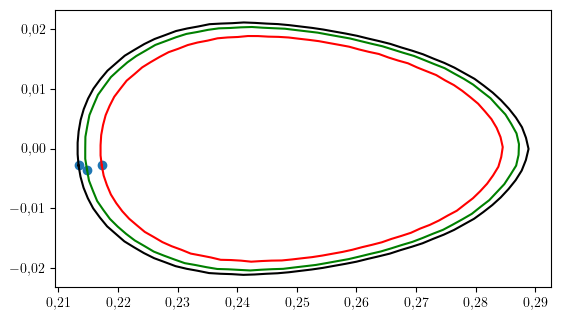

In [15]:
def k0Ln_k0LB(ne_interpol1, factor_densidad1, factor_B, num, angulo, B_xint1, B_yint1, B_zint1):
    from scipy.constants import e, m_e, epsilon_0, c #constantes físicas
    f_calentamiento1 = 2.45e9
    omega1 =  2*np.pi*f_calentamiento1
    lambda_0 = c/f_calentamiento1
    k0 = 2*np.pi/lambda_0
    
    #aumento_factor_ne = np.array([1.480, 1.573, 1.665, 1.758, 1.850, 1.995, 2.068, 2.14])
    aumento_factor_ne = np.array([1.480, 1.850,  2.14])
    #aumento_factor_B0 = np.array([0.9950, 0.975, 1.000, 1.025, 1.050])
    n_filas = aumento_factor_ne.shape[0]
    x_pos_uhr = np.ndarray((n_filas, num), dtype=np.float64)
    y_pos_uhr = np.ndarray((n_filas, num), dtype=np.float64)
    x_pos_o = np.ndarray((n_filas, num), dtype=np.float64)
    y_pos_o = np.ndarray((n_filas, num), dtype=np.float64)
    x_uhr = np.ndarray((n_filas), dtype=np.float64)
    y_uhr = np.ndarray((n_filas), dtype=np.float64)
    x_o = np.ndarray((n_filas), dtype=np.float64)
    y_o = np.ndarray((n_filas), dtype=np.float64)
    B_neto1 = np.sqrt( np.power(B_xint1,2) + np.power(B_yint1,2) + np.power(B_zint1,2) )
    ind_LB_r = np.ndarray((n_filas), dtype=np.float64)
    ind_LB_z = np.ndarray((n_filas), dtype=np.float64)
    ind_Ln_r = np.ndarray((n_filas,), dtype=np.float64)
    ind_Ln_z = np.ndarray((n_filas,), dtype=np.float64)
    for i in range(n_filas):
        wpe1 = ((factor_densidad1*aumento_factor_ne[i]*ne_interpol1)*np.power(e,2))/(m_e*epsilon_0) #cuadrado de la frecuencia
        wpe1_norm = np.sqrt( ((factor_densidad1*aumento_factor_ne[i]*ne_interpol1)*np.power(e,2))/(m_e*epsilon_0)) /omega1 #cuadrado de la frecuencia
        wce1 = ((e)/(m_e))*B_neto1*factor_B
        wuh_norm1 = (np.sqrt(np.power(wce1,2) + wpe1))/omega1
        grid_r, grid_z = np.mgrid[0.19893:0.303797:297j, -0.0289025:0.0289019:165j]
        levels = np.arange(1.0, 1.01, 1)
        uh = plt.contour(grid_r,grid_z, wuh_norm1, levels, linestyles = 'dashed', colors = 'red', linewidths = 1)
        pe = plt.contour(grid_r,grid_z, wpe1_norm, levels, linestyles = 'dashed', colors = 'red', linewidths = 1)
        plt.close() #no mostrar el gráfico
        for item1 in uh.collections:
            for i11 in item1.get_paths():
                v11 = i11.vertices
                x11 = v11[:, 0]
                y11 = v11[:, 1]
                
        for item in pe.collections:
            for i1 in item.get_paths():
                v1 = i1.vertices
                x1 = v1[:, 0]
                y1 = v1[:, 1]
        
        #Interpolar un contorno: https://stackoverflow.com/questions/33962717/interpolating-a-closed-curve-using-scipy
        tck11, _ = interpolate.splprep([x11, y11], s=0, per=True)
        tck1, _ = interpolate.splprep([x1, y1], s=0, per=True)
        
        # Evaluar el contorno
        x11_inter, y11_inter = interpolate.splev(np.linspace(0, 1, num), tck11)
        x1_inter, y1_inter = interpolate.splev(np.linspace(0, 1, num), tck1)
        
        #Asignacion
        x_pos_uhr[i] = x11_inter
        y_pos_uhr[i] = y11_inter
        x_pos_o[i] = x1_inter
        y_pos_o[i] = y1_inter
        
        angulo_uhr = np.arctan2(-y_pos_uhr[i], (x_pos_uhr[i]-0.247))
        index = find_nearest1(angulo_uhr, np.radians(angulo))
        x_uhr[i] = x_pos_uhr[i,index]
        y_uhr[i] = y_pos_uhr[i,index]
        
        angulo_pe = np.arctan2(-y_pos_o[i], (x_pos_o[i]-0.247))
        index = find_nearest1(angulo_pe, np.radians(angulo))
        x_o[i] = x_pos_o[i,index]
        y_o[i] = y_pos_o[i,index]
        
        
    #Cálculo de L_n
    r = np.linspace(0.19893, 0.303797, 297)
    z = np.linspace(-0.0289025, 0.0289019, 165)
    delta_x = r[1]-r[0]
    delta_y = np.abs(z[1]-z[0])
    gradiente_x, gradiente_y = np.gradient(ne_interpol1, delta_x, delta_y) 
    ne1_grad = np.sqrt(gradiente_x**2 + gradiente_y**2)
    #ne1_grad = np.abs(gradiente_x)
    L_n = ne_interpol1 /(ne1_grad)
    
    #Cálculo de L_B
    gradiente_xB, gradiente_yB = np.gradient(B_neto1, delta_x, delta_y) 
    B_grad = np.sqrt(gradiente_xB**2 + gradiente_yB**2)
    #B_grad = np.abs(gradiente_xB)
    L_B = B_neto1 /(B_grad)
    
    
    #Elegir si es x0 o xuhr
    for j1 in range(n_filas) : 
        ind_Ln_r[j1] = np.searchsorted(r, x_o[j1], side="left")
        ind_Ln_z[j1] = np.searchsorted(z, y_o[j1], side="left")
        ind_LB_r[j1] = np.searchsorted(r, x_o[j1], side="left")
        ind_LB_z[j1] = np.searchsorted(z, y_o[j1], side="left")
        L_n_final = L_n[ind_Ln_r.astype(int), ind_Ln_z.astype(int)]
        L_B_final = L_B[ind_LB_r.astype(int), ind_LB_z.astype(int)]
    
    for n in range(n_filas) : 
        print("En la densidad", aumento_factor_ne[n])
        print("En la posición", "(", x_o[n],",",y_o[n],")", "el k0L_n es", k0*L_n_final[n] )
        print("En la posición", "(", x_o[n],",",y_o[n],")", "el k0L_B es", k0*L_B_final[n] )
        print("El radio de curvatura es", (np.sqrt((x_uhr[n]-0.247)**2 + y_uhr[n]**2))*100, 'cm' )
        print("La distancia entre o y uhr es", (np.sqrt( (x_uhr[n]-x_o[n])**2 + (y_uhr[n]-y_o[n])**2 ) )*100, 'cm')
        print("El radio de O es", (np.sqrt( (x_o[n]-0.247)**2 + (y_o[n])**2 ) )*100, 'cm')
        print("\n")
    #Graficos
    colors = np.array(['red', 'green', 'black'])
    
    #for j in range(x_pos_uhr.shape[0]) : plt.plot(x_pos_uhr[j], y_pos_uhr[j], color = colors[j])
    #print(x_uhr, y_uhr)
    #plt.scatter(x_uhr, y_uhr)
    
    for k in range(x_pos_o.shape[0]) : plt.plot(x_pos_o[k], y_pos_o[k], color = colors[k])
    print(x_o, y_o)
    plt.scatter(x_o, y_o)
    plt.gca().set_aspect("equal")
    
k0Ln_k0LB(ne_interpol, 6.1405, 1, 100, -178, B_xint, B_yint, B_zint)
#k0Ln_k0LB(ne_interpol, 6.1405, 1, 100, -175, B_xint, B_yint, B_zint)

En el campo 0.95
En la posición ( 0.279703171003894 , -0.01175571039290579 ) el k0L_n es 0.24609425539768218
En la posición ( 0.279703171003894 , -0.01175571039290579 ) el k0L_B es 9.069993172437943
El radio de curvatura es 3.605177915830283 cm
La distancia entre o y uhr es 0.13085070858105996 cm
El radio de O es 3.4751893769286992 cm


En el campo 1.0
En la posición ( 0.279703171003894 , -0.01175571039290579 ) el k0L_n es 0.24885106810179805
En la posición ( 0.279703171003894 , -0.01175571039290579 ) el k0L_B es 7.306530998977649
El radio de curvatura es 3.5914362286733623 cm
La distancia entre o y uhr es 0.1174901503983467 cm
El radio de O es 3.4751893769286992 cm


En el campo 1.05
En la posición ( 0.279703171003894 , -0.01175571039290579 ) el k0L_n es 0.2330854173939562
En la posición ( 0.279703171003894 , -0.01175571039290579 ) el k0L_B es 10.273170790374895
El radio de curvatura es 3.600643763099874 cm
La distancia entre o y uhr es 0.12738618387638206 cm
El radio de O es 3.475189

/tmp/ipykernel_63652/1923889212.py:76: RuntimeWarning: divide by zero encountered in true_divide
  L_n = ne_interpol1 /(ne1_grad)
/tmp/ipykernel_63652/1923889212.py:76: RuntimeWarning: invalid value encountered in true_divide
  L_n = ne_interpol1 /(ne1_grad)
/tmp/ipykernel_63652/1923889212.py:81: RuntimeWarning: invalid value encountered in true_divide
  L_B = B_neto1 /(B_grad)


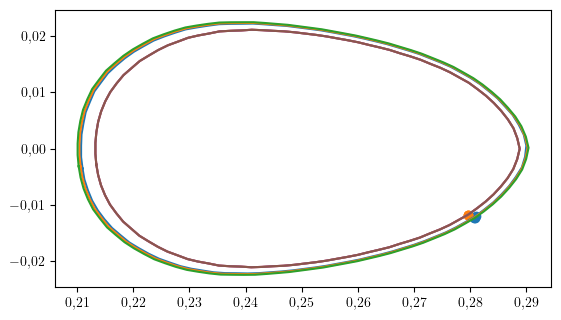

In [4]:
def k0Ln_k0LB_B(ne_interpol1, factor_densidad1, factor_ne, num, angulo, B_xint1, B_yint1, B_zint1):
    from scipy.constants import e, m_e, epsilon_0, c #constantes físicas
    f_calentamiento1 = 2.45e9
    omega1 =  2*np.pi*f_calentamiento1
    lambda_0 = c/f_calentamiento1
    k0 = 2*np.pi/lambda_0
    aumento_factor_B0 = np.array([0.95, 1.00, 1.05])
    
    n_filas = aumento_factor_B0.shape[0]
    x_pos_uhr = np.ndarray((n_filas, num), dtype=np.float64)
    y_pos_uhr = np.ndarray((n_filas, num), dtype=np.float64)
    x_pos_o = np.ndarray((n_filas, num), dtype=np.float64)
    y_pos_o = np.ndarray((n_filas, num), dtype=np.float64)
    x_uhr = np.ndarray((n_filas), dtype=np.float64)
    y_uhr = np.ndarray((n_filas), dtype=np.float64)
    x_o = np.ndarray((n_filas), dtype=np.float64)
    y_o = np.ndarray((n_filas), dtype=np.float64)
    ind_LB_r = np.ndarray((n_filas), dtype=np.float64)
    ind_LB_z = np.ndarray((n_filas), dtype=np.float64)
    ind_Ln_r = np.ndarray((n_filas,), dtype=np.float64)
    ind_Ln_z = np.ndarray((n_filas,), dtype=np.float64)
    B_neto1 = np.sqrt( np.power(B_xint1,2) + np.power(B_yint1,2) + np.power(B_zint1,2) )
    for i in range(n_filas):
        wpe1 = ((factor_densidad1*factor_ne*ne_interpol1)*np.power(e,2))/(m_e*epsilon_0) #cuadrado de la frecuencia
        wpe1_norm = np.sqrt( ((factor_densidad1*factor_ne*ne_interpol1)*np.power(e,2))/(m_e*epsilon_0)) /omega1 #cuadrado de la frecuencia
        wce1 = ((e)/(m_e))*B_neto1*aumento_factor_B0[i]
        wuh_norm1 = (np.sqrt(np.power(wce1,2) + wpe1))/omega1
        grid_r, grid_z = np.mgrid[0.19893:0.303797:297j, -0.0289025:0.0289019:165j]
        levels = np.arange(1.0, 1.01, 1)
        uh = plt.contour(grid_r,grid_z, wuh_norm1, levels, linestyles = 'dashed', colors = 'red', linewidths = 1)
        pe = plt.contour(grid_r,grid_z, wpe1_norm, levels, linestyles = 'dashed', colors = 'red', linewidths = 1)
        plt.close() #no mostrar el gráfico
        for item1 in uh.collections:
            for i11 in item1.get_paths():
                v11 = i11.vertices
                x11 = v11[:, 0]
                y11 = v11[:, 1]
                
        for item in pe.collections:
            for i1 in item.get_paths():
                v1 = i1.vertices
                x1 = v1[:, 0]
                y1 = v1[:, 1]
        
        #Interpolar un contorno: https://stackoverflow.com/questions/33962717/interpolating-a-closed-curve-using-scipy
        tck11, _ = interpolate.splprep([x11, y11], s=0, per=True)
        tck1, _ = interpolate.splprep([x1, y1], s=0, per=True)
        
        # Evaluar el contorno
        x11_inter, y11_inter = interpolate.splev(np.linspace(0, 1, num), tck11)
        x1_inter, y1_inter = interpolate.splev(np.linspace(0, 1, num), tck1)
        
        #Asignacion
        x_pos_uhr[i] = x11_inter
        y_pos_uhr[i] = y11_inter
        x_pos_o[i] = x1_inter
        y_pos_o[i] = y1_inter
        
        angulo_uhr = np.arctan2(-y_pos_uhr[i], (x_pos_uhr[i]-0.247))
        index = find_nearest1(angulo_uhr, np.radians(angulo))
        x_uhr[i] = x_pos_uhr[i,index]
        y_uhr[i] = y_pos_uhr[i,index]
        
        angulo_pe = np.arctan2(-y_pos_o[i], (x_pos_o[i]-0.247))
        index = find_nearest1(angulo_pe, np.radians(angulo))
        x_o[i] = x_pos_o[i,index]
        y_o[i] = y_pos_o[i,index]
        
    #Cálculo de L_n
    r = np.linspace(0.19893, 0.303797, 297)
    z = np.linspace(-0.0289025, 0.0289019, 165)
    delta_x = r[1]-r[0]
    delta_y = np.abs(z[1]-z[0])
    gradiente_x, gradiente_y = np.gradient(ne_interpol1, delta_x, delta_y) 
    ne1_grad = np.sqrt(gradiente_x**2 + gradiente_y**2)
    L_n = ne_interpol1 /(ne1_grad)
    
    #Cálculo de L_B
    gradiente_xB, gradiente_yB = np.gradient(B_neto1, delta_x, delta_y) 
    B_grad = np.sqrt(gradiente_xB**2 + gradiente_yB**2)
    L_B = B_neto1 /(B_grad)
    
   #Elegir si es x_o o x_uhr
    for j1 in range(n_filas) : 
        ind_Ln_r[j1] = np.searchsorted(r, x_uhr[j1], side="left")
        ind_Ln_z[j1] = np.searchsorted(z, y_uhr[j1], side="left")
        ind_LB_r[j1] = np.searchsorted(r, x_uhr[j1], side="left")
        ind_LB_z[j1] = np.searchsorted(z, y_uhr[j1], side="left")
        L_n_final = L_n[ind_Ln_r.astype(int), ind_Ln_z.astype(int)]
        L_B_final = L_B[ind_LB_r.astype(int), ind_LB_z.astype(int)]
    
    
    for n in range(n_filas) : 
        print("En el campo", aumento_factor_B0[n])
        print("En la posición", "(", x_o[n],",",y_o[n],")", "el k0L_n es", k0*L_n_final[n] )
        print("En la posición", "(", x_o[n],",",y_o[n],")", "el k0L_B es", k0*L_B_final[n] )
        print("El radio de curvatura es", (np.sqrt((x_uhr[n]-0.247)**2 + y_uhr[n]**2))*100, 'cm' )
        #print("En la posición", "(", x_o[n],",",y_o[n],")", "el k0L_n es", k0*L_n_final[n] )
        #print("En la posición", "(", x_o[n],",",y_o[n],")", "el k0L_B es", k0*L_B_final[n] )
        #print("El radio de curvatura es", (np.sqrt((x_o[n]-0.247)**2 + y_o[n]**2))*100, 'cm' )
        print("La distancia entre o y uhr es", (np.sqrt( (x_uhr[n]-x_o[n])**2 + (y_uhr[n]-y_o[n])**2 ) )*100, 'cm')
        print("El radio de O es", (np.sqrt( (x_o[n]-0.247)**2 + (y_o[n])**2 ) )*100, 'cm')
        print("\n")
    #Graficos
    colors = np.array(['red', 'green', 'black'])
    
    for j in range(x_pos_uhr.shape[0]) : plt.plot(x_pos_uhr[j], y_pos_uhr[j])
    #print(x_uhr, y_uhr)
    plt.scatter(x_uhr, y_uhr)
    
    for k in range(x_pos_o.shape[0]) : plt.plot(x_pos_o[k], y_pos_o[k]) #color = colors[k]
    #print(x_o, y_o)
    plt.scatter(x_o, y_o)
    plt.gca().set_aspect("equal")
    
    
k0Ln_k0LB_B(ne_interpol, 6.1405, 2.14, 100, 18, B_xint, B_yint, B_zint)